# DSCI 100 Project Report

## Predicting Data Contribution of a Video Game Research Server Using Self-Identified Information

By Anushri Sharma

### 1. Introduction
As video games continue to grow in popularity, understanding player behavior has become essential for optimizing server resources and improving the overall gaming experience. This has been a key challenge for developers and researchers. To mitigate this, a UBC Computer Science research group, led by Professor Frank Wood, is collecting Minecraft server usage data to explore questions around player recruitment, engagement, and resource allocation. Their goal is to use data-driven approaches to optimize player outreach and server management. In this project, our central question is:

**Can we predict whether a player will contribute a high amount of data (measured by total hours played) based on their self-identified gaming experience, age, gender, and subscription status?**

This central question will help us identify the player types that will generate the most amount of data early on so outreach efforts can focus on those who are the most valuable to the study. Additionally, having accurate predictions of user playtime is important for planning server capacity and optimizing recruitment strategies for players who are most likely to engage with the online research server.

### Dataset Description

We will be using two datasets provided by the research team called sessions.csv and players.csv and will be using a k-NN classification model for this project. 
#### User Demograpic and Summary Data
First, we will look at the players dataset which contains observations on 196 players, with one row for each.
| Variable                       | Brief Explanation                                                                 |
|-------------------------------|------------------------------------------------------------------------------------|
| Experience                           | Self-reported experience level (Beginner, Amateur, Regular, Veteran, Pro)                                                                     |
| Gender                        | Player's gender identity (e.g., Male, Female, Non-binary)                          |
| hashedEmail                     | Unique anonymized identifyer for each player         |
| Subscribe                     | Whether the player subscribed to the newsletter (TRUE/FALSE)                      |
| Played Hours                  | Total hours the player spent on the server                                        |
| Name                  | Player name                                      |
| Age                 | Player age                                        |

Some potential issues that may exist within this data set are that self reported experience may not correlate with actual player performance, some players have recorded 0 hours played, columns such as `experience`, `subscribe`, and `gender` contain high amounts of repetition, and the `name`column may not be very useful for prediction purposes


#### Session Log Data
This dataset contains 1535 observations on the login information for every player, with a single row for each.
| Variable                       | Brief Explanation                                                                 |
|-------------------------------|------------------------------------------------------------------------------------|
| hashedEmail                           | Unique anonymized identifyer for each player                                                                     |
| start_time                        | Timestamp indicating when a gaming session starts in dd/mm/yyy                         |
| end_time                     | Timestamp indicating when a gaming session ends in dd/mm/yyy         |
| original_start_time                     | The Unix timestamp version of start_time, used for more precise calculations                      |
| original_emd_time                 | The Unix timestamp version of start_time, used for more precise calculations                                           |

Some potential issues that may exist within this dataset are that the time format must be standardized for analysis, overlapping session timestamps have not yet been validated, and duplicate or inconsiderate records may often occur because there could be technical server logging errors within the dataset. 

### 2. Methods & Results
First we will begin by reading and inspecting the 2 datasets. 
1. **Player Profile Dataset** contains information on player age, gender, self-identified experience level, subscription status, and total played hours.
2. **Session Log Dataset** contains timestamped login and logout information for each player which can also be used to calculate total hours played.

Our response or target variable will be `played_hours` which is the total hours a player has played. Our predictor variables will be `experience`, `subscribe`, `gender`, and `age`. We will not be using `hashedEmail`, `name`, `start_time`, `end_time`, `original_start_time`, `original_end_time`. The last four variables would only be needed for a time-based/numerical analysis, but we will be conducting a categorical analysis.

We will clean the data by removing rows with missing or invalid values and ensuring consistent formatting for categorical cariables like experience, gender, and subscribe. Additionally, since we are using a classification model instead of a regression model, we will create a target class call `contribution_level` from the `played_hours` column. 

| Contribution Level                       | Played Hours Range                                                                |
|-------------------------------|------------------------------------------------------------------------------------|
| Low                           | 0 to ≤2 hours                                                    |
| Medium                        | 	>2 to ≤10 hours         |
| High                     | >10 hours        |

- Experience (categorical)

- Subscribe (boolean)

- Gender (categorical)

- Age (numeric)

#### 0. Setting Up the Environment

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### 1. Loading the Datasets From the Data Folder

In [2]:
sessions <- read_csv("data/sessions.csv")
players <- read_csv("data/players.csv")

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### 3. Cleaning and Wrangling the Data into a Tidy Format
We will now start cleaning our data so it is in a tidy format and additionally filtering it so the variables are relevant for the analysis.

In [3]:
# We will start by cleaning the sessions dataset
sessions_data_cleaned <- sessions |>
    select(hashedEmail, start_time, end_time) |>
    mutate (
        start_time = dmy_hm(start_time),
        end_time = dmy_hm(end_time),
        session_hours = as.numeric(difftime(end_time, start_time, units="hours"))
        ) |>
    group_by(hashedEmail) |>
    summarize(played_hours = sum(session_hours, na.rm=TRUE), .groups = "drop")
# sessions_data_cleaned

# Now we will go ahead and clean the players dataset
players_data_cleaned <- players |>
    select(-played_hours, -name) |>
    rename(age = Age) 
# players_data_cleaned

# We will now merge the two datasets together by hashedEmail
cleaned_data <- players_data_cleaned |> 
    inner_join(sessions_data_cleaned, by = "hashedEmail") |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(experience = as.factor(experience)) |>
    mutate(gender = as.factor(gender))
    # mutate(age = as.factor(age))


# cleaned_data

# Lastly, we will create our target variable called high_contributor
highest_times <- median(cleaned_data$played_hours, na.rm = TRUE)
cleaned_data <- cleaned_data|>
    mutate(high_contributor = as.factor(if_else(played_hours > highest_times ,TRUE,FALSE)))
cleaned_data

experience,subscribe,hashedEmail,gender,age,played_hours,high_contributor
<fct>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,Male,9,33.65000000,TRUE
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Male,17,4.25000000,TRUE
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,Male,17,0.08333333,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,Prefer not to say,17,0.08333333,FALSE
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,Male,17,2.98333333,TRUE
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,Other,NA,0.25000000,FALSE


First, we started off by cleaning our two datasets `players.csv` and `sessions.csv`. In `sessions_data_cleaned`, we selected the three variables we wanted to use for the analysis and converted `start_time` and `end_time` into date-time objects . Following that, we then calculated an accurate session duration using the difference between start and end time and then stored that in a new variable. We did this because played_hours may not be an accurate represenation of how much a player actually games because most of the information in the players dataset is self reported. I used hashedEmail to summarise the total time spend accross all sessions, and then finally created a new dataset with the total `player_hours` for each user.

For the player dataset, I removed the unecessary columns and renamed Age to age in order to match the other column names. In the next section, we worked towards mergin the data sets and after conducting some external research, I was able to use `inner_join` on `hashedEmail` to ensure all relevant variable and the new `player_hours` were retained in the merged dataset.

Lastly, after calculating the median of `player_hours` across all players in the data, I was able to create a neww variable called `high_contributor` to label whether a player has contributed a large amount of data - if their total played_hours is greater than the median - to serve as the target for classification in the model we are building.

#### 4. Splitting Data into Training and Testing Data
We will now work on splitting the data into a training set and testing set. For this split. we will use 75% of data for the training set and 25% for the testing set. This will ensure that we have enough data to train the model while also retaining enough unknown data to test the model later on. We will stratify the split based on our target variable `high_contributor` to ensure an equal class representation, a random seed, and additionally 10 fold cross validation to ensure minimal bias in the model.

In [43]:
data_split <- initial_split(cleaned_data, prop = 0.75, strata = high_contributor)
training_data <- training(data_split)
testing_data <- testing(data_split)

training_data <- training_data |> 
    mutate(high_contributor = as.factor(high_contributor)) |>
    drop_na() |> 
    distinct()

players_vfold <- vfold_cv(training_data, v = 10, strata = high_contributor)

nrow(training_data)
nrow(testing_data)

[1] 91

[1] 32

Now that the data has been split into a training and testing set, we can create summary statistics before we go forward with visualization. 

#### 4. Produce Summary Statistics for Training Data

gender,high_contributor,n
<fct>,<fct>,<int>
Agender,TRUE,1
Female,FALSE,6
Female,TRUE,14
⋮,⋮,⋮
Prefer not to say,FALSE,3
Prefer not to say,TRUE,3
Two-Spirited,FALSE,2


experience,high_contributor,n
<fct>,<fct>,<int>
Amateur,FALSE,15
Amateur,TRUE,16
Beginner,FALSE,6
⋮,⋮,⋮
Regular,TRUE,8
Veteran,FALSE,16
Veteran,TRUE,7


subscribe,high_contributor,n
<fct>,<fct>,<int>
FALSE,FALSE,17
FALSE,TRUE,6
TRUE,FALSE,28
TRUE,TRUE,40


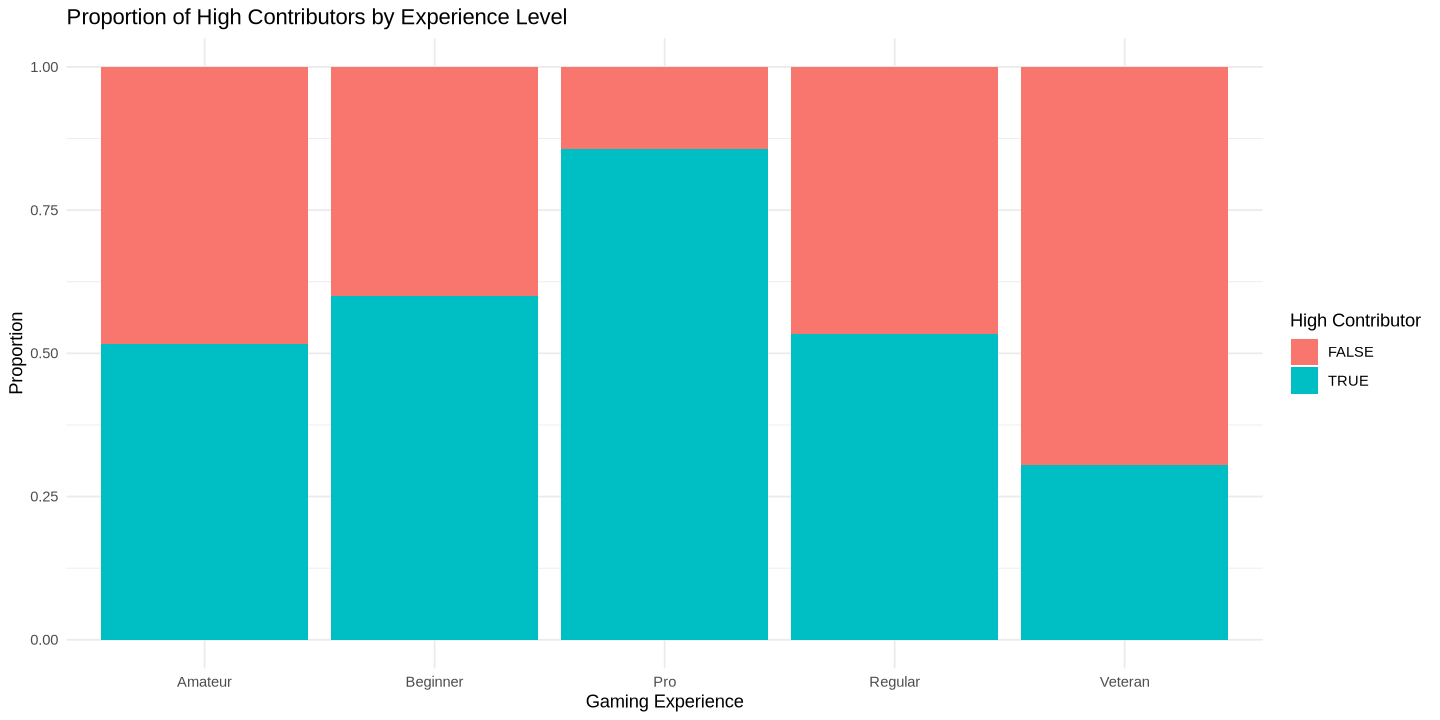

In [44]:
summary_training <- training_data |>
    group_by(high_contributor) |>
    summarize (
        mean_age = mean(age, na.rm = TRUE),
        sd_age = sd(age, na.rm = TRUE),
        mean_hrs = mean(played_hours, na.rm = TRUE),
        sd_hrs = sd(played_hours, na.rm = TRUE), 
        .groups = "drop"
        )

training_data |>
  count(gender, high_contributor)

training_data |>
  count(experience, high_contributor)

training_data |>
  count(subscribe, high_contributor)

training_plot_experience <- ggplot(training_data, aes(x = experience, fill = high_contributor)) +
  geom_bar(position = "fill") +
  labs(title = "Proportion of High Contributors by Experience Level",
       x = "Gaming Experience",
       y = "Proportion",
       fill = "High Contributor") +
  theme_minimal()

training_plot_experience

#### 5. Preprocess the Training Data and Fit KNN Classification Model
Moving forwared, we will now work on preprocessing our data.


In [52]:
set.seed(123)
player_recipe <- recipe(high_contributor ~ age + gender + experience + subscribe, data = training_data) |>
    step_dummy(all_nominal_predictors()) |> 
    step_zv(all_predictors()) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_mode("classification") |>
    set_engine("kknn")

knn_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(player_recipe)

knn_results <- tune_grid(
  knn_workflow,
  resamples = players_vfold,
  grid = tibble(neighbors = 1:10)
)

knn_metrics <- knn_results |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
  arrange(desc(mean))

head(knn_metrics)

neighbors,mean
<int>,<dbl>
9,0.5891667
10,0.5766667
6,0.5641667
5,0.5616667
2,0.5530556
1,0.5516667


Figure 1.1: Table of k-values

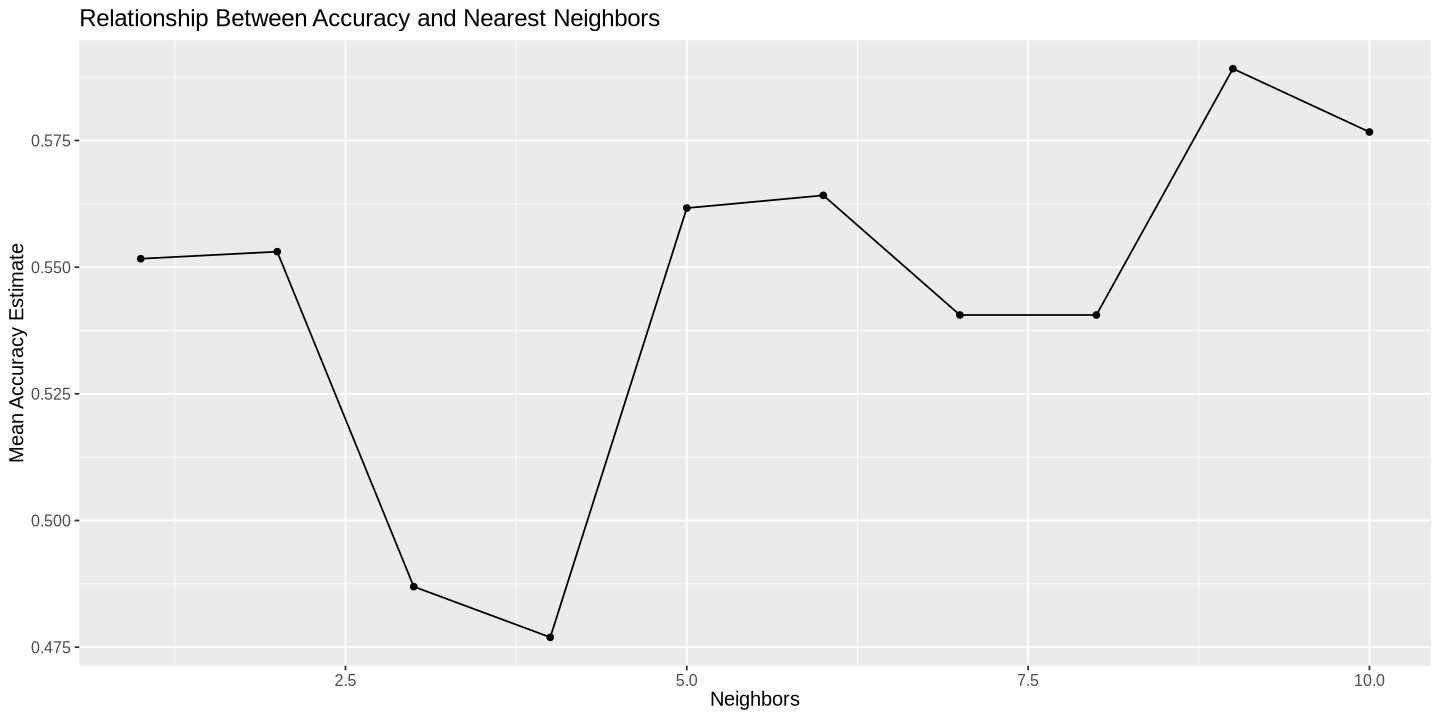

In [54]:
options(repr.plot.height = 6, repr.plot.width = 12)
accuracy_vs_k <- ggplot(knn_metrics, aes(x=neighbors,y=mean)) +
    geom_point() +
    geom_line() +
    labs(
        x="Neighbors",
        y="Mean Accuracy Estimate",
        title="Relationship Between Accuracy and Nearest Neighbors"
        ) +
    theme(text = element_text(size=12))
accuracy_vs_k

In [59]:
#Now we will create the final model specification using the selected k of 9
knn_tune <- nearest_neighbor(weight_func = "rectangular",neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

workflow_tune <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_tune) |>
    fit(data = training_data)

workflow_tune

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_dummy()
• step_zv()
• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4065934
Best kernel: rectangular
Best k: 9

#### 6. Evaluate Final Tuned KNN-Classification Model


In [64]:
test_preds <- predict(workflow_tune, new_data = testing_data) |>
  bind_cols(testing_data)

test_accuracy <- test_preds |>
  metrics(truth = high_contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy")

conf_mat(truth = high_contributor, estimate = .pred_class, data = test_preds)

|>

          Truth
Prediction FALSE TRUE
     FALSE     5   10
     TRUE     11    6